In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import openturns as ot
import otkerneldesign as otkd
import ctbenchmark as ctb

In [3]:
from matplotlib import rc, rcParams, style
#style.use('default')
rc('font', **{'family': 'Times'})
rc('text', usetex=True)
rc('font', size=16)# Set the default text font size
rc('axes', titlesize=20)# Set the axes title font size
rc('axes', labelsize=16)# Set the axes labels font size
rc('xtick', labelsize=14)# Set the font size for x tick labels
rc('ytick', labelsize=16)# Set the font size for y tick labels
rc('legend', fontsize=16)# Set the legend font size

In [4]:
g = ot.SymbolicFunction(['x'], ['x * sin(x) + sin(6 * x)'])
#g = ot.SymbolicFunction(['x'], ['x * sin(x) + sin(6 * x) + 50'])

In [5]:
grid_size = 1000
dim = 1
lowerbound = [0.] * dim
upperbound = [12.] * dim
mesher = ot.IntervalMesher([grid_size-1] * dim)
interval = ot.Interval(lowerbound, upperbound)
mesh = mesher.build(interval)
nodes = mesh.getVertices()
x_node = np.array(nodes).flatten()
y_true = np.array(g(nodes)).flatten()

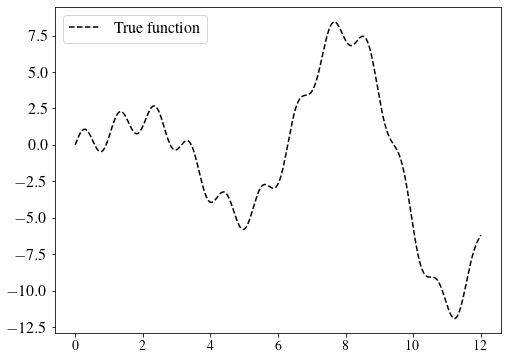

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(x_node, y_true, color='k', linestyle='dashed', label='True function')
plt.legend(loc='best');

In [7]:
n = 5
distribution = ot.Gumbel(1.4, 0.) + 4
#distribution = ot.Normal(6., 1.)
#x_train = distribution.getSample(5)
#x_train = np.array([1.2, 2., 5., 8.2, 10.]).reshape(-1, 1)
x_train = np.array([1.2, 2., 5., 6.5, 8.2, 10.]).reshape(-1, 1)
#x_train = np.array([1.2, 3., 6.5, 10.]).reshape(-1, 1)
y_train = g(x_train)

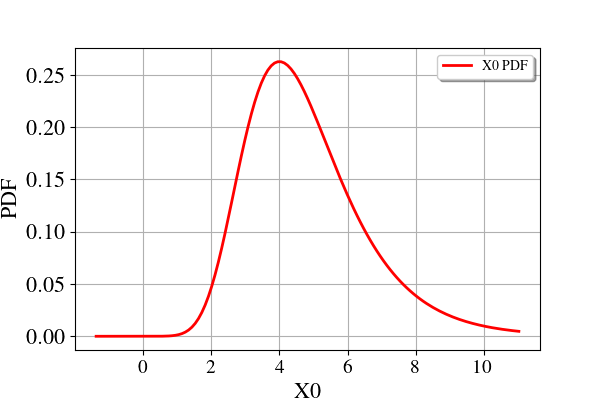

In [8]:
distribution.drawPDF()

In [9]:
kriging_results = ctb.CentralTendencyBenchmark().build_kriging(x_train, y_train)
predictor = kriging_results.getMetaModel()
y_predictor = np.array(predictor(nodes)).flatten()

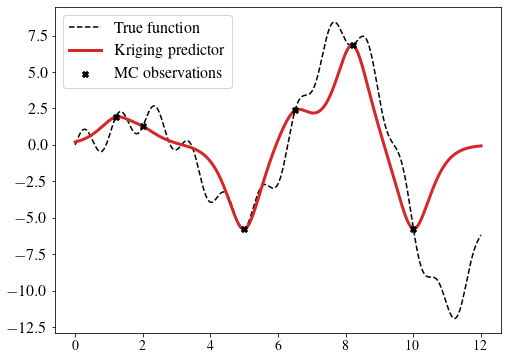

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(x_node, y_true, color='k', linestyle='dashed', label='True function', zorder=0)
plt.plot(x_node, y_predictor, color='C3', linewidth=3, label='Kriging predictor', zorder=1)
plt.scatter(x_train, y_train, marker='X', color='k', label='MC observations', zorder=2)
plt.legend(loc='best');

## Simulate new trajectories

In [11]:
process = ot.ConditionedGaussianProcess(kriging_results, mesh)
trajectories_nb = 1000
trajectories = process.getSample(trajectories_nb)

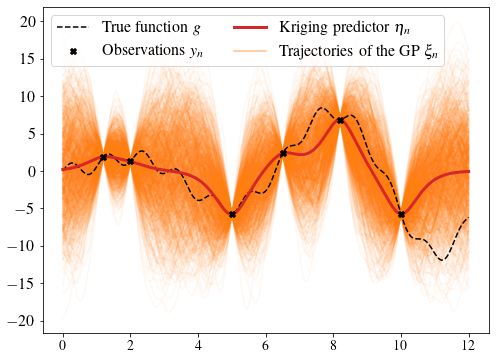

In [12]:
plt.figure(figsize=(8, 6))
for t in range(trajectories_nb):
    traj = np.array(trajectories.getMarginal(0)[t]).flatten()
    plt.plot(x_node, traj, color='C1', alpha=0.05, zorder=0)

plt.plot(x_node, y_true, color='k', linestyle='dashed', label='True function $g$', zorder=1)
plt.scatter(x_train, y_train, marker='X', color='k', label='Observations $y_n$', zorder=3)
plt.plot(x_node, y_predictor, color='C3', linewidth=3, label='Kriging predictor $\eta_n$', zorder=2)
plt.plot(x_node, traj, color='C1', alpha=0.5, label='Trajectories of the GP $\\xi_n$', zorder=0)

plt.legend(loc='upper left', ncol=2);

In [13]:
inputRandomVector = ot.RandomVector(distribution)
compositeRandomVector = ot.CompositeRandomVector(g, inputRandomVector)
ref_sample = compositeRandomVector.getSample(int(1e6))
ref_mean = ref_sample.computeMean()[0]
ref_mean

-1.2650143046984157

In [14]:
arithmetic_mean = y_train.computeMean()[0]
arithmetic_mean

0.1445842116493104

## BQ estimator

In [15]:
theta = 0.6
#kernel = ot.MaternModel([theta], [1.0], 2.5)
kernel = ot.SquaredExponential([theta], [1.0])
bq = otkd.BayesianQuadratureWeighting(kernel=kernel, distribution=distribution)
BQ_weights = bq.compute_bayesian_quadrature_weights(ot.Sample(x_train.reshape(-1, 1)))
BQ_mean = bq.compute_bayesian_quadrature_mean(ot.Sample(x_train.reshape(-1, 1)), y_train)
BQ_var = bq.compute_bayesian_quadrature_variance(ot.Sample(x_train.reshape(-1, 1)))
BQ_distribution = ot.Normal(BQ_mean, np.sqrt(BQ_var))
print("BQ mean: {:.3f} \nBQ variance: {:.3f}".format(BQ_mean, BQ_var))

BQ mean: -1.075 
BQ variance: 0.125


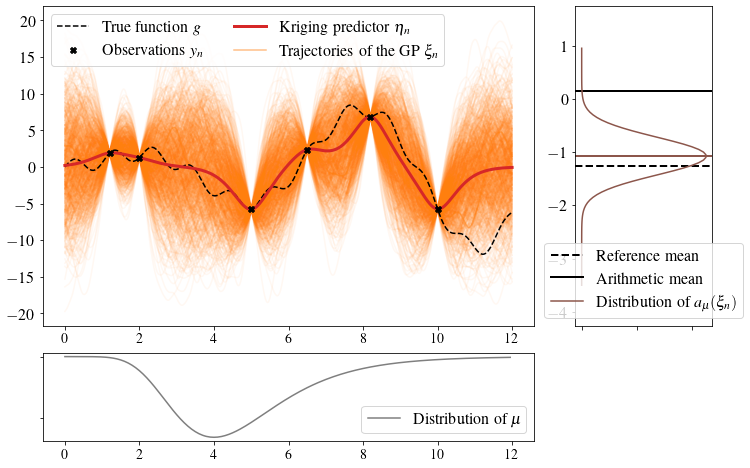

In [17]:
fig = plt.figure(figsize=(12 ,8))
grid = plt.GridSpec(4, 4, hspace=0.3, wspace=0.3)
main_ax = fig.add_subplot(grid[:-1, 0:-1])
#y_hist = fig.add_subplot(grid[:-1, -1], xticklabels=[], sharey=main_ax)
y_hist = fig.add_subplot(grid[:-1, -1], xticklabels=[])
x_hist = fig.add_subplot(grid[-1, 0:-1], yticklabels=[], sharex=main_ax)
# GP plotting with 1000 random trajectories
for t in range(trajectories_nb):
    traj = np.array(trajectories.getMarginal(0)[t]).flatten()
    main_ax.plot(x_node, traj, color='C1', alpha=0.05, zorder=0)
main_ax.plot(x_node, y_true, color='k', linestyle='dashed', label='True function $g$', zorder=1)
main_ax.scatter(x_train, y_train, marker='X', color='k', label='Observations $y_n$', zorder=3)
main_ax.plot(x_node, y_predictor, color='C3', linewidth=3, label='Kriging predictor $\eta_n$', zorder=2)
main_ax.plot(x_node, traj, color='C1', alpha=0.5, label='Trajectories of the GP $\\xi_n$', zorder=0)
main_ax.legend(loc='upper left', ncol=2)

# Bottom input distribution
x_plot1 = np.arange(0., 12, 0.05).reshape(-1, 1)
x_hist.plot(x_plot1, distribution.computePDF(x_plot1), color='C7', label='Distribution of $\mu$')
x_hist.invert_yaxis()
x_hist.legend(loc='best')

# Right BQ distribution 
x_plot2 = np.arange(-3.5, 1., 0.05).reshape(-1, 1)
y_hist.axhline(y=ref_mean, color='k', linestyle='dashed', linewidth=2 , label="Reference mean")
y_hist.axhline(y=arithmetic_mean, color='k', linewidth=2 , label="Arithmetic mean")
y_hist.axhline(y=BQ_mean, linewidth=2, color='C5')
y_hist.plot(BQ_distribution.computePDF(x_plot2), x_plot2, color='C5', label='Distribution of $a_\\mu(\\xi_n)$')
y_hist.legend(loc='lower center')
y_hist.set_ylim([ref_mean - 3., ref_mean + 3])
plt.savefig('res/posterior_distribution_centered.pdf', bbox_inches='tight');